In [1]:
# 在3.ipynb
# 我们证明了如果不限制时间，我们收益的期望的最大值是正无穷
# 现在，我们考虑首达时的期望ETₚ
# 要赚钱速度最大化
# max p/ETₚ

In [2]:
using DifferentialEquations
using Distributions
using Plots
using KernelDensity
using QuadGK
global θ=1.0
global μ=100.0
global σ=1.0
global t0=0.0
global dt=0.01
global T=1000.0

1000.0

In [3]:
function FPT(a,b) #首达时间
    if a==b
        return 0.0
    end 
    X=OrnsteinUhlenbeckProcess(θ,μ,σ,t0,μ+a)
    X.dt=dt
    calculate_step!(X,dt,nothing,nothing)
    for t in dt:dt:T
        accept_step!(X,dt,nothing,nothing)
        if a<b && X.curW>=μ+b
            return X.curt
        end
        if a>b && X.curW<=μ+b
            return X.curt
        end
    end
    return Inf
end
function ET(a,b)
    N=1000
    S=Array{Float64}(undef,N)
    for i in 1:N
        S[i]=FPT(a,b)
    end
    r=findall(x->x!=Inf,S)
    if length(r)!=length(S)
        println("P(reached)=",length(r)/length(S))
        println("T is too small when a=$a b=$b")
        error()
    end
    return mean(S[r])
end

ET (generic function with 1 method)

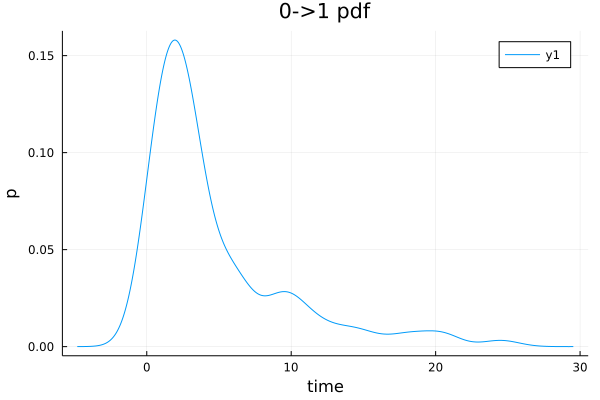

In [4]:
# 固定ab，看FPT的分布
function pdf_FPT(a,b)
    N=100
    S=Array{Float64}(undef,N)
    for i in 1:N
        S[i]=FPT(a,b)
    end
    sort!(S)
    r=searchsorted(S,Inf)
    U = kde(@view S[1:r.start-1])
    return U
end
U=pdf_FPT(0,1)
plot(U.x,U.density,title="0->1 pdf",xlabel="time",ylabel="p")

In [5]:
#https://www.tandfonline.com/doi/full/10.1080/15326340500294702
#https://www.jstor.org/stable/pdf/3214232.pdf?refreqid=excelsior%3A96be3992d0803f4dbdc727dc74fc0fb6&ab_segments=&origin=&acceptTC=1
#https://arxiv.org/pdf/1810.02390.pdf
#只给了a<b,但可以是负的
#ParabolicCylinderD就是Hermite
#怎么求一个方程所有的根？？？

In [6]:
using Roots
using MathLink
D(ν,z) = weval(W"ParabolicCylinderD"(ν,z))
dD(ν,z) = weval(W`D[ParabolicCylinderD[x,z],x]/.x->ν`;ν=ν,z=z)
function pdf_series(a,b,t)
    N=10
    if a>b
        a=-a
        b=-b
    end
    α=-sqrt(2*Θ)*a/σ
    β=-sqrt(2*Θ)*b/σ
    roots=find_zeros(ν->D(ν,β),0,100)
    first_term=-θ*exp(-θ*(b^2-a^2)/2)
    second_term=0.0
    for ν in roots
        second_term+=D(ν,α)/dD(ν,β)*exp(-θ*ν*t)
    end
    return first_term*second_term
end
#找根太慢了，我放弃
#这个密度我先不管了，
#我直接查Expectation
#https://www.jstor.org/stable/pdf/3214232.pdf?refreqid=excelsior%3Ac898a6131321041fa9af26a9032e2278&ab_segments=&origin=
#这里面也算了矩

pdf_series (generic function with 1 method)

In [7]:
using SpecialFunctions
ψ(k,z)=polygamma(k,z)
C(n,k)=binomial(n,k)
function ρ(n,k)
    if k==1
        return 1
    end
    A=zeros(k-1,k-1)
    for i in 1:k-1
        for j in 1:k-1
            if i>=j
                A[i,j]=(ψ(i-j,n/2)-ψ(i-j,1))*C(i,j)
            elseif i==j-1
                A[i,j]=-1
            end
        end
    end
    return det(A)
end
function ϕ(k,z)
    N=max(big(50),ℯ*z^2)
    if k==1
        return 1/2*sum([(sqrt(2)*z)^n/factorial(n)*gamma(n/2) for n in 1:N])
    end
    return k/2^k*sum([(sqrt(2)*z)^n/factorial(n)*gamma(n/2)*ρ(n,k) for n in 1:N])
end
function ET_theory(a,b)
    α=sqrt(2*θ)/σ*a
    β=sqrt(2*θ)/σ*b
    return 1/θ*(ϕ(1,β)-ϕ(1,α))
end
#论文做了标准化
#dXt=-Θ*Xt*dt+σ*dWt
#d(Xt/σ)=dWt-Θ*(Xt/σ)*dt
#t=s/Θ
#d(1/σ*Xs)=dWs-(1/σ*Xt)*ds
#big(20)渐进速度是什么？
#是 (√2*z*e/n*sqrt(n/2e))^n=(ez²/n)^(n/2) 对n求和
#是 n~ez²

ET_theory (generic function with 1 method)

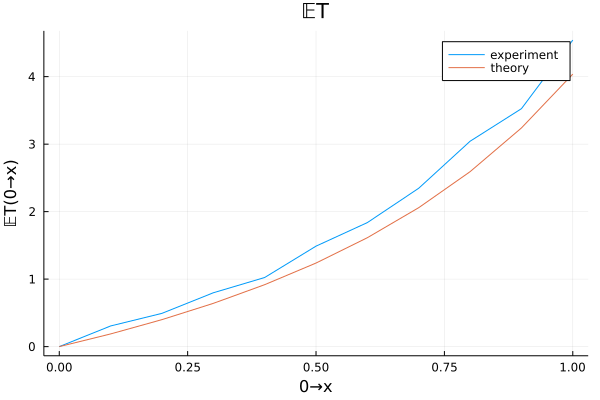

In [10]:
global Θ=1.0
global σ=1.0
x=0:0.1:1
y_experiment=ET.(0,x)
y_theory=ET_theory.(0,x)
#y_trick=[ET_trick(0,x[i]) for i in length(x)]
fig=plot(x,y_experiment,xlabel="0→x",ylabel="𝔼T(0→x)",title="𝔼T",label="experiment")
plot!(x,y_theory,label="theory")

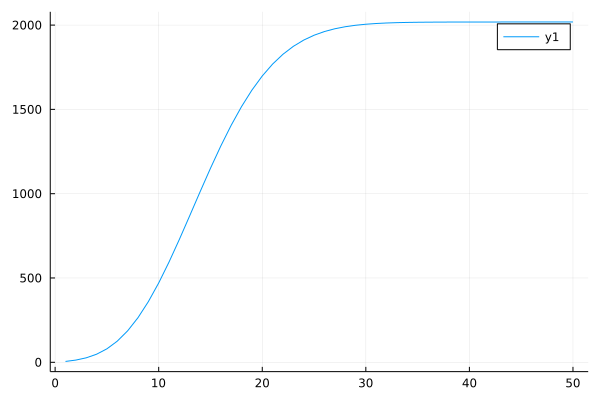

In [11]:
N=1:big(50)
z=4
plot(N,[1/2*sum([(sqrt(2)*z)^n/factorial(n)*gamma(n/2) for n in 1:N[i]]) for i in N])